# Read Angle-Averaged Fornax Models

Read and plot the ASCII data from the angle-averaged Fornax 3D supernova simulations. The data were downloaded from https://www.astro.princeton.edu/~burrows/nu-emissions.3d/.

There are two types of files available: files with luminosity versus energy and time, and luminosity integrated over energy vs. time.

In [2]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

from glob import glob

from astropy.io import ascii, fits
from astropy.table import Table
from astropy import units as u

mpl.rc('font', size=14)

## Spectrum Reader

In [3]:
def read_spectrum(filename):
    """Read spectrum ASCII file, return an astropy table.
    The files contain tables of luminosity vs. energy and time.
    
    Parameters
    ==========
    filename : str
        Name of the spectrum ASCII file.
    
    Returns
    =======
    spectrum : astropy.table.Table
        Binned spectrum in time and energy, in correct units.
    """
    # Set up the column names.
    ebin_names = ['E{:02d}'.format(e-2) for e in range(2, 14)]
    lbin_names = ['lum{:02d}'.format(l-14) for l in range(14, 26)]
    colnames = ['time'] + ebin_names + lbin_names

    # Read the file. The first column is time,
    # columns 2-13 are the bin energy for each of the twelve bins,
    # and columns 14-25 are the spectra in each bin (in 1050 erg s−1 MeV−1)
    # for each time.
    spectrum = ascii.read(filename, names=colnames)
    
    # Hackish way to extract progenitor mass from filename.
    tokens = filename.split('_')
    mass = 0.
    for t in tokens:
        if 'M' in t:
            mass = float(t[:-1])
    spectrum.meta['mass'] = mass
    
    if 'inu0' in filename:
        spectrum.meta['type'] = 'e'
    elif 'inu1' in filename:
        spectrum.meta['type'] = 'ebar'
    else:
        spectrum.meta['type'] = 'x'
    
    # Set up correct units.
    spectrum['time'].unit = 's'
    for ebin in ebin_names:
        spectrum[ebin].unit = 'MeV'
    for lbin in lbin_names:
        spectrum[lbin].unit = '1e50 * erg / (s * MeV)'

    return spectrum

## Spectrum Plotters

Plot spectra at a given time, or the entire time series.

In [35]:
def plot_spectrum_timeslice(spectrum, idx=0, time=None):
    """Plot the spectrum vs. energy at a particular time slice.
    
    Parameters
    ==========
    spectrum : astropy.table.Table
        Spectrum table (energy and luminosity bins vs. time).
    idx : int
        Index of the timeslice (if specified by user).
    time : float
        Time to plot (find nearest in spectrum table).
        
    Returns
    =======
    fig : matplotlib.Figure
        Figure object for plotting/saving.
    """
    if time is not None:
        idx = (np.abs(spectrum['time'] - time)).argmin()

    t = spectrum['time'][idx]
    ene = [spectrum[e][idx] for e in spectrum.columns[1:13]]
    lum = [spectrum[l][idx] for l in spectrum.columns[13:]]
    
    # Energies given in bin centers.
    # This rigamarole gets the edges and widths.
    logE = np.log10(ene)
    dlogE = 0.5*np.diff(logE)[0]
    logE_bins = logE - dlogE
    logE_bins = np.concatenate((logE_bins, [logE[-1] + dlogE]))
    e_bins = 10**logE_bins
    dE = [ene - e_bins[:-1],
          e_bins[1:] - ene]
    
    fig, ax = plt.subplots(1,1, figsize=(7,5))
    ax.errorbar(ene, lum, xerr=dE, yerr=0, fmt='o')
    
    if spectrum.meta['type'] == 'e':
        pcltype = r'$\nu_e$'
    elif spectrum.meta['type'] == 'ebar':
        pcltype = r'$\bar{\nu}_e$'
    else:
        pcltype = r'$\nu_x$'
        
    mass = spectrum.meta['mass']
    
    ax.set(xlabel='energy [MeV]',
           xscale='log',
           ylabel=r'{:s} $\Delta L / \Delta E_i$ [$10^{{50}}$ erg s$^{{-1}}$ MeV $^{{-1}}$]'.format(pcltype),
#            ylabel=r'$\mathcal{{L}}_{:s}$ [$10^{{50}}$ erg s$^{{-1}}$ MeV $^{{-1}}$]'.format(pcltype),
           title='{:g}$M_\odot$, time: {:.2f} s'.format(mass, t))
    fig.tight_layout()
    return fig

In [58]:
def plot_spectrum(spectrum):
    """Plot the energy spectrum vs. time.
    
    Parameters
    ==========
    spectrum : astropy.table.Table
        Spectrum table (energy and luminosity bins vs. time).
        
    Returns
    =======
    fig : matplotlib.Figure
        Figure object for plotting/saving.
    """
    
    t = spectrum['time']
    ene = [spectrum[e] for e in spectrum.columns[1:13]]
    lum = [spectrum[l] for l in spectrum.columns[13:]]
    
    emin = np.log10(np.min(ene))
    emax = np.log10(np.max(ene))

    if spectrum.meta['type'] == 'e':
        pcltype = r'$\nu_e$'
    elif spectrum.meta['type'] == 'ebar':
        pcltype = r'$\bar{\nu}_e$'
    else:
        pcltype = r'$\nu_x$'
        
    mass = spectrum.meta['mass']

    fig, ax = plt.subplots(1,1, figsize=(7,5))
    im = ax.imshow(lum, extent=[t[0], t[-1], emin, emax],
                   origin='lower', vmin=0, vmax=150)
    cb = fig.colorbar(im, ax=ax)
    cb.set_label(r'{:s} $\Delta L / \Delta E_i$ [$10^{{50}}$ erg s$^{{-1}}$ MeV $^{{-1}}$]'.format(pcltype))
    
    ratio = 1.0 * (t[-1] - t[0]) / (emax - emin)
    ax.set(aspect=ratio,
           xlabel='time [s]',
           ylabel='log$_{10}$(energy / MeV)',
           title='{:g}$M_\odot$'.format(mass))

    fig.tight_layout()
    return fig

## Example Plots

Read in all the spectra files. Note that spectra of type "0" correspond to $\nu_e$ fluxes, spectra of type "1" correspond to $\nu_\bar{e}$, and spectra of type "2" correspond to $\nu_x$ where $x=\mu,\tau$, and anti-particles.

In [59]:
spectra_files = sorted(glob('data/lum_spec_*.dat'))
e_spectra = [f for f in spectra_files if 'inu0.dat' in f]
ebar_spectra = [f for f in spectra_files if 'inu1.dat' in f]
x_spectra = [f for f in spectra_files if 'inu2.dat' in f]

### $\nu_\bar{e}$ spectrum

Plot the anti-nu-e spectrum for one of the progenitor models.
This will produce the dominant signal in IceCube.

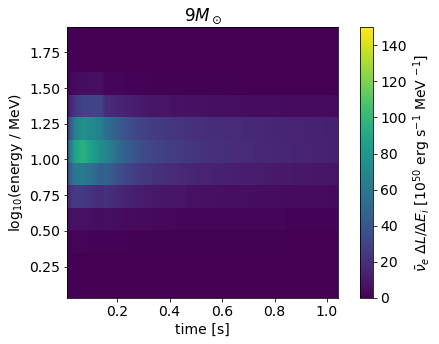

In [60]:
s = read_spectrum(ebar_spectra[-1])
fig = plot_spectrum(s)

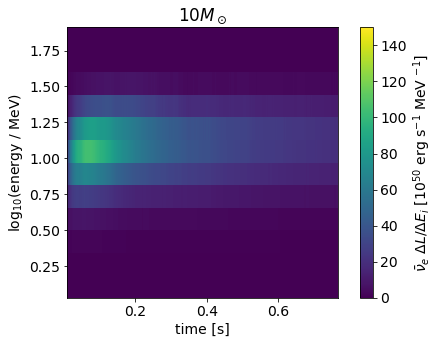

In [61]:
s = read_spectrum(ebar_spectra[0])
fig = plot_spectrum(s)

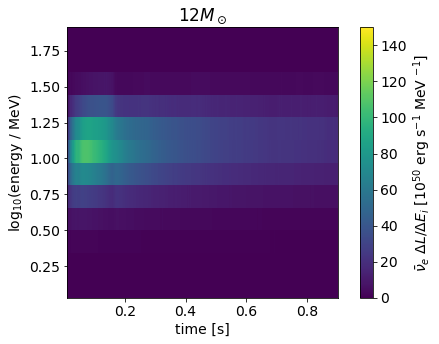

In [62]:
s = read_spectrum(ebar_spectra[1])
fig = plot_spectrum(s)

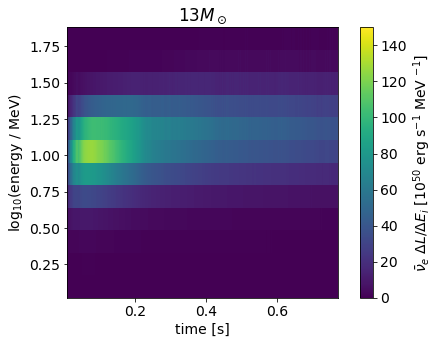

In [63]:
s = read_spectrum(ebar_spectra[2])
fig = plot_spectrum(s)

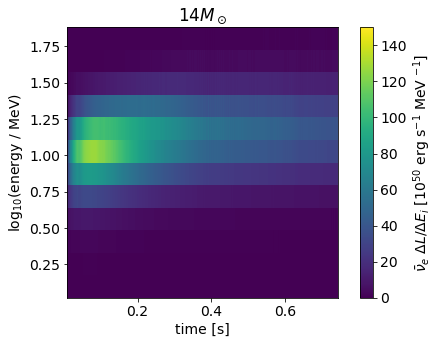

In [64]:
s = read_spectrum(ebar_spectra[3])
fig = plot_spectrum(s)

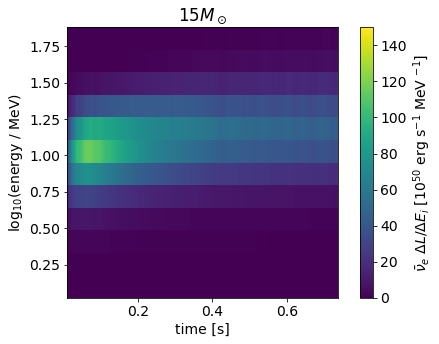

In [65]:
s = read_spectrum(ebar_spectra[4])
fig = plot_spectrum(s)

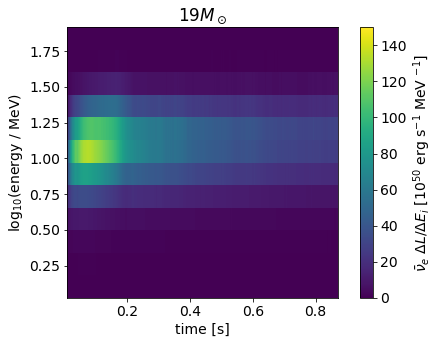

In [66]:
s = read_spectrum(ebar_spectra[5])
fig = plot_spectrum(s)

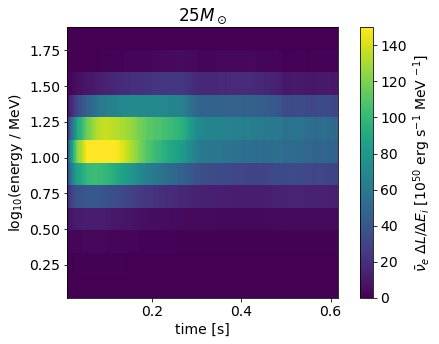

In [67]:
s = read_spectrum(ebar_spectra[6])
fig = plot_spectrum(s)

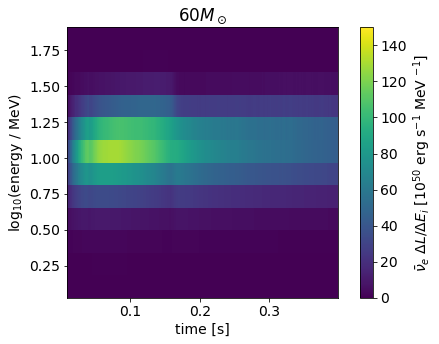

In [68]:
s = read_spectrum(ebar_spectra[7])
fig = plot_spectrum(s)

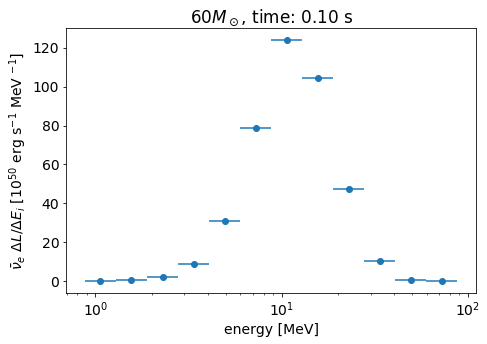

In [69]:
fig = plot_spectrum_timeslice(s, time=0.1)